# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

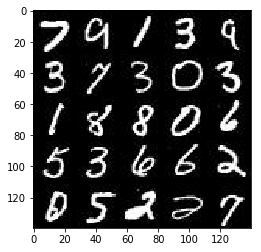

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

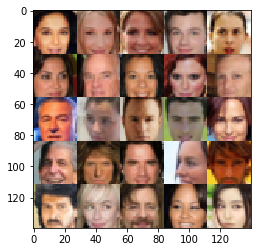

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_data = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_data, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    base_shape = images.get_shape().as_list()[1]
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Shape 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(x1*0.2, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*0.2, x2)
        #7x7x128
        
        #x3 = tf.layers.conv2d(x2, 256, 5, strides=5, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=True)
        #x3 = tf.maximum(x3*0.2, x3)
        
        flattened = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*0.2, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2*0.2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3*0.2, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    losses = []
    image_channels = 1 if data_image_mode == 'L' else 3
    image_width = data_shape[1]
    image_height = data_shape[2]
    input_data, z_data, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_data, z_data, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images*2
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #Run Optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_data: batch_images, z_data: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_data: batch_images, z_data: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_data: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({input_data: batch_images, z_data: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps%100 == 0:
                    show_generator_output(sess, 10, z_data, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3237... Generator Loss: 0.0714
Epoch 1/2... Discriminator Loss: 2.7332... Generator Loss: 0.1589
Epoch 1/2... Discriminator Loss: 1.7861... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 1.7949... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.9234... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 1.7197... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 1.6502... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 1.7579... Generator Loss: 0.5649
Epoch 1/2... Discriminator Loss: 1.7126... Generator Loss: 0.5892
Epoch 1/2... Discriminator Loss: 1.6378... Generator Loss: 0.6378


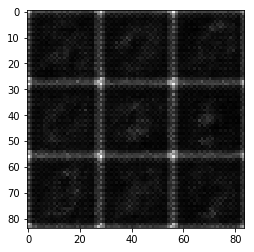

Epoch 1/2... Discriminator Loss: 1.6221... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.6037... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 1.5782... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.5131... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.7302


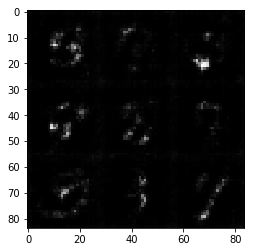

Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 1.0055


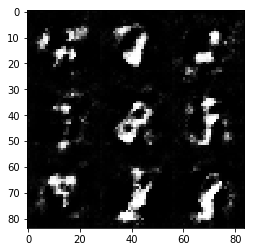

Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.6757
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.6905


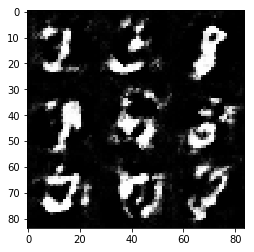

Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.6633


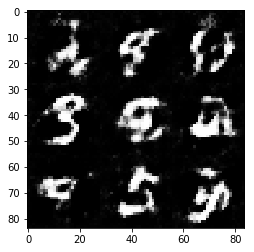

Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.7222
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 1.1643


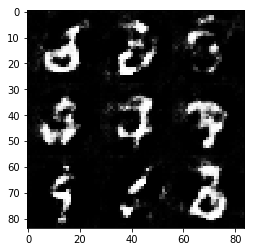

Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 1.0901
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 1.1920
Epoch 2/2... Discriminator Loss: 1.2458... Generator Loss: 1.1059
Epoch 2/2... Discriminator Loss: 1.2458... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.7541


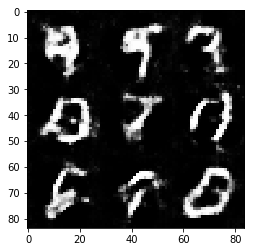

Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.5928
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.5729
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 1.0388
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.9726
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 1.0871
Epoch 2/2... Discriminator Loss: 1.3265... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.9307


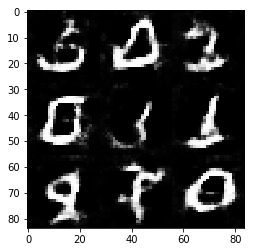

Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.4099... Generator Loss: 1.1549
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.5886
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.8279


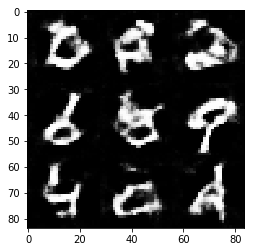

Epoch 2/2... Discriminator Loss: 1.4448... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.5770
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.7690


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1659... Generator Loss: 0.1065
Epoch 1/1... Discriminator Loss: 2.1399... Generator Loss: 0.3374
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 2.0374... Generator Loss: 0.2605
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.7100... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5534


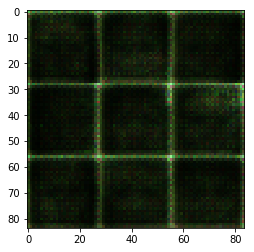

Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.9810... Generator Loss: 0.2877
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.6586... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 2.2053... Generator Loss: 0.2151
Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.7316... Generator Loss: 0.3846
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.4006


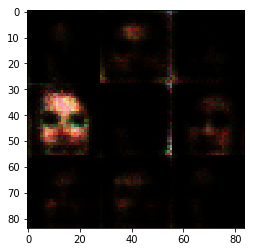

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.5558


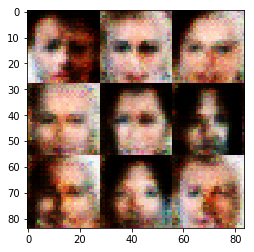

Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.7584
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 2.9520
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 2.5507
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 2.6346
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 2.3434
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 2.0566
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 2.7407


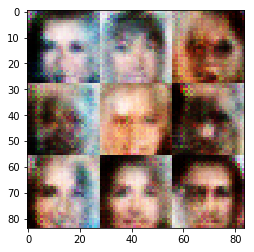

Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.3330


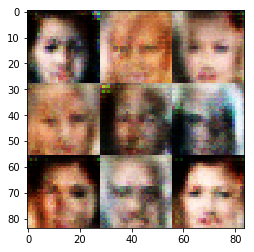

Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8751


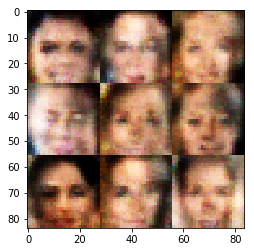

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 2.1809... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.5839


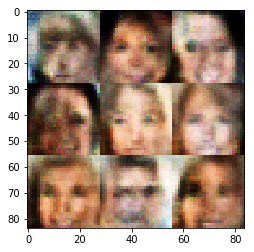

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.8415... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6245


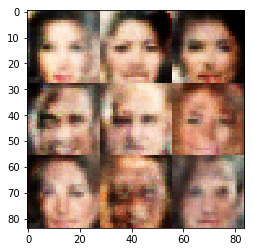

Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7879


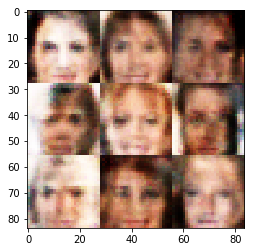

Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.7476
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 1.6998


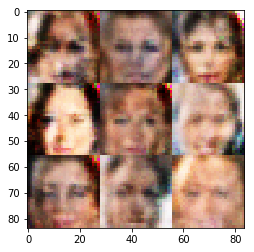

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.7643... Generator Loss: 0.3277
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 1.5184
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.7900


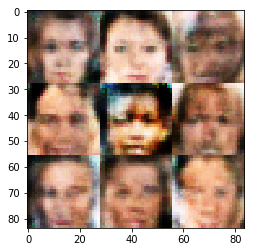

Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 1.1652


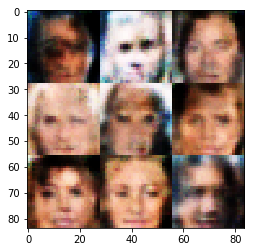

Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.3371


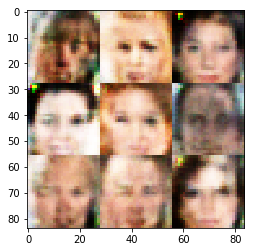

Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 1.9174


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.